**Import Modules**


In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import open3d as o3d
import numpy as np
sys.path.append(os.chdir("../"))
from HALSS_utils.halss_utils import halss_data_packet, flags_required, parameters, coarse_landing_region_selection, multithread_fine_site_selection
from HALSS_utils.plotting_utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
--> [WARNING]: Failed to import airsim packages. If you are using the Jupyter Notebook, this can be safely ignored.


**Initialize Parameters, Flags, and HALSS Datapacket**

In [2]:
# #####################
# Flags
# #####################
flags = flags_required()
flags.flag_plot_origin = False
flags.flag_plot_circles = False # Only relevant for Airsim simulation
flags.flag_show_images = False
flags.flag_save_images = False
flags.flag_timing = False
flags.flag_offset = False
flags.flag_debug = False
flags.flag_coarse_method = 'nn' # Choose "geo" for inclination-based HD or "nn" for learning-based HD
flags.flag_jupyter_plot = False

# #####################
# Initialize Parameters
# #####################
params = parameters()
params.x_cell_size_coarse = 4 # Size of cell in x direction for Coarse Downsampling
params.y_cell_size_coarse = 4 # Size of cell in y direction for Coarse Downsampling
params.x_cell_size_fine = 0.001 # Size of cell in x direction for Fine Downsampling
params.y_cell_size_fine = 0.001 # Size of cell in y direction for Fine Downsampling
params.alpha = 10 # Maximum allowable inclination angle in degrees
params.max_sites = 12 # Maximum number of sites to be considered
params.grid_res = 480 # Resolution of grid to be used for segmentation, must be multiple of 32
params.thresh = 0.1 # Threshold for variance-aware safety map threshold
params.num_mc_samples = 30 # Number of Monte Carlo samples to be used for variance-aware safety map
params.media_save_path = os. getcwd() + '\\figures\\HALSS\\' # Path to save images

# #####################
# Initialize HALSS Datapacket
# #####################
halss_global = halss_data_packet()
halss_global.num_circles = params.max_sites

halss_global.x_cell_size = params.x_cell_size_coarse # Size of cell in x direction for Coarse Downsampling
halss_global.y_cell_size = params.y_cell_size_coarse # Size of cell in y direction for Coarse Downsampling


**Import Demo Pointcloud**


In [3]:
halss_global.pcd_full = np.load(os. getcwd() + '\\HALSS\\demo_pointcloud.npy')
halss_global.pcd_new = halss_global.pcd_full

pcd_combined = o3d.geometry.PointCloud()
pcd_combined.points = o3d.utility.Vector3dVector(halss_global.pcd_full)
#o3d.visualization.draw_plotly([pcd_combined], point_sample_factor=0.2) # Draws in Notebook but looks bad
#o3d.visualization.draw_geometries([pcd_combined]) # Draws in separate window but looks good

**Convert Pointcloud to Surface Normal**

To create the surface normal, a we linearly interpolate a function to fit the pointcloud. We then sample the function at equal grid spacings. The gradient of the surface is then found and used to create the unit normal vector $\hat{u} = \frac{\begin{bmatrix} -\delta x & -\delta y & 1 \end{bmatrix}} {\left|\left|\begin{bmatrix} -\delta x & -\delta y & 1 \end{bmatrix}\right|\right|}$. This vector, $\hat{u}$, is represented by the $r$, $g$, and $b$ values which is unit normal vector to the surface at that point.

In [4]:
halss_global.pcd_culled_dict = {}
halss_global.downsample_pointcloud_dict()
halss_global.downsample_pointcloud() # Downsample point cloud data

**Coarse Hazard Detection**

c:\Users\chris\Documents\HALO\HALSS\HALSS_utils\point_cloud_to_image.py:41: RuntimeWarning: invalid value encountered in cast
  normal_image = np.flipud(np.dstack((channel_red, channel_green, channel_blue)).astype(np.uint8))


--> [HALSS: Using  NVIDIA GeForce RTX 3090  for learning based Coarse HD]
c:\Users\chris\Documents\HALO


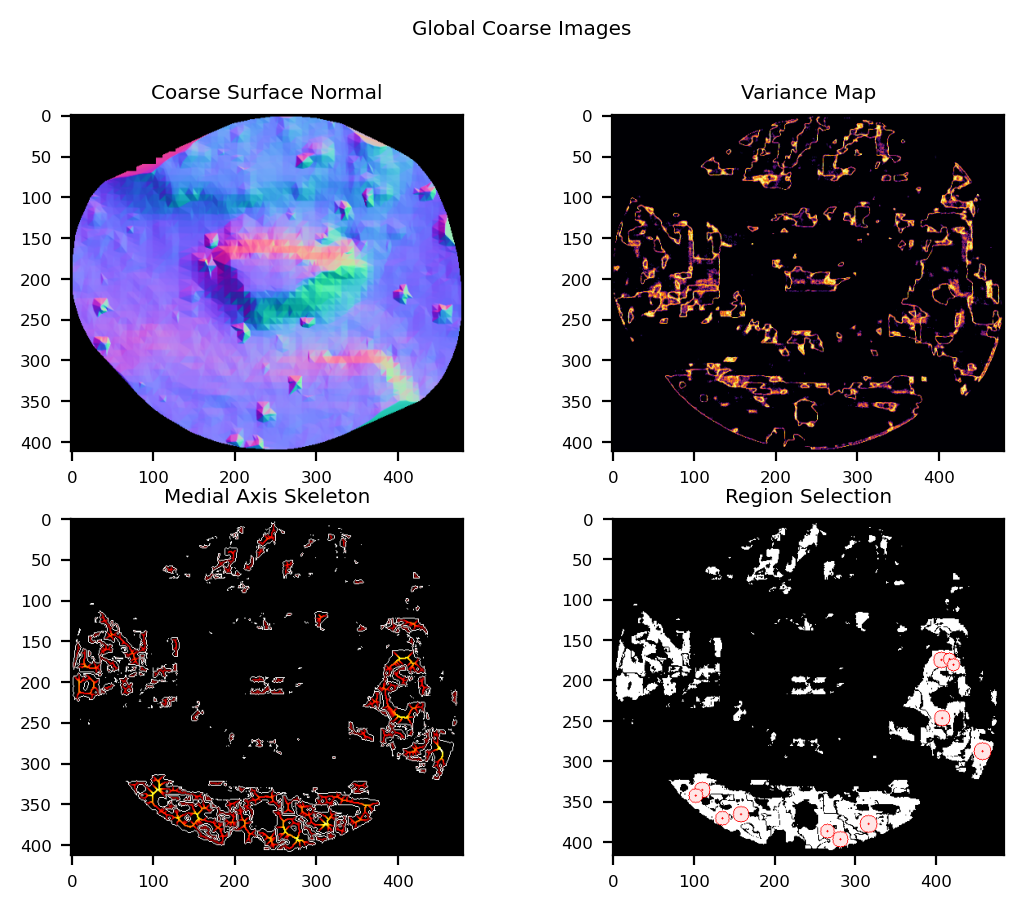

In [5]:
halss_global = coarse_landing_region_selection(halss_global, flags, params)
plot_coarse_images(halss_global)

**Fine Landing Hazard Detection**

c:\Users\chris\Documents\HALO\HALSS\HALSS_utils\seg_utils.py:56: RuntimeWarning: invalid value encountered in divide
  X = (X - xmin) / (xmax - xmin)
c:\Users\chris\Documents\HALO\HALSS\HALSS_utils\halss_utils.py:623: RuntimeWarning: invalid value encountered in cast
  skel_color = cv2.applyColorMap((normalize(skeleton)*255).astype(np.uint8), cv2.COLORMAP_HOT)


<Figure size 640x480 with 0 Axes>

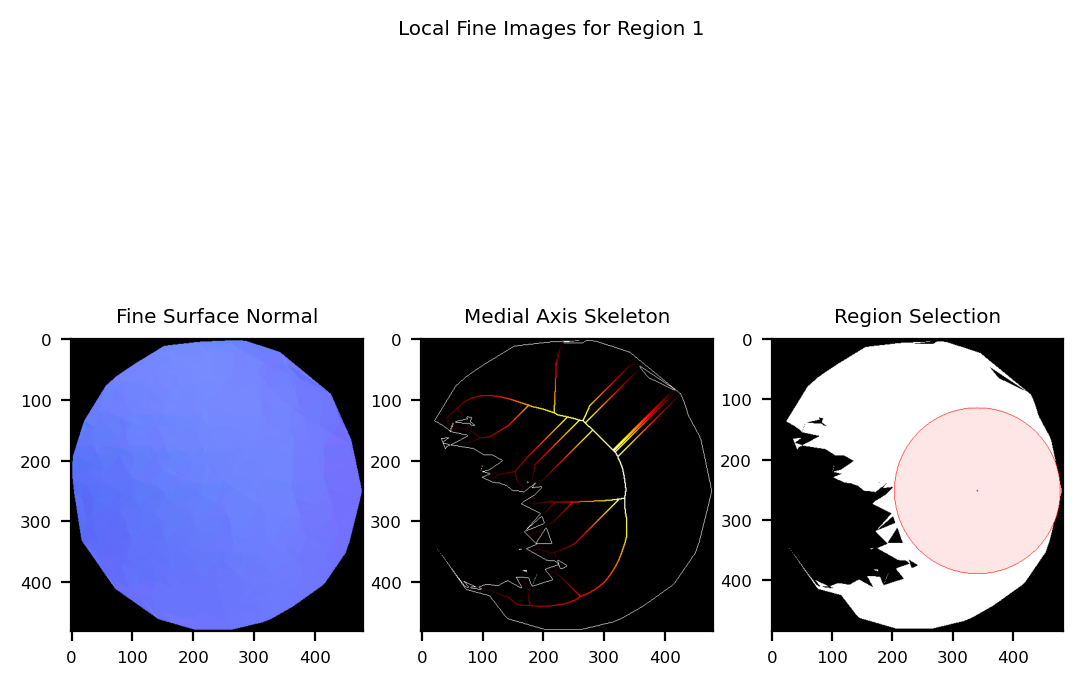

<Figure size 640x480 with 0 Axes>

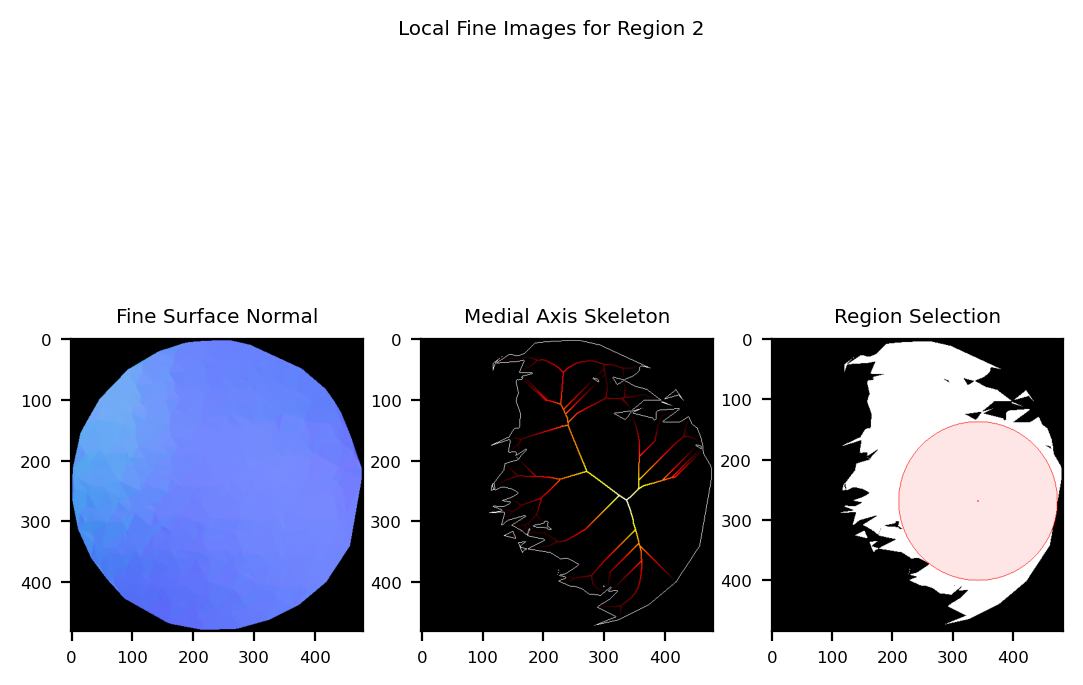

<Figure size 640x480 with 0 Axes>

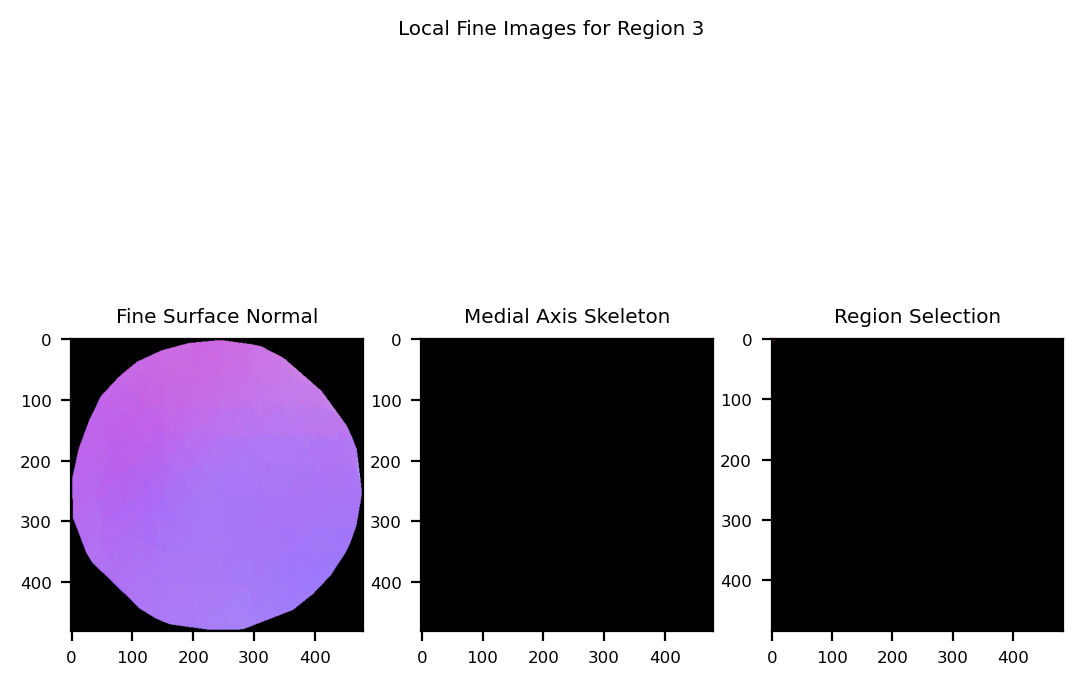

<Figure size 640x480 with 0 Axes>

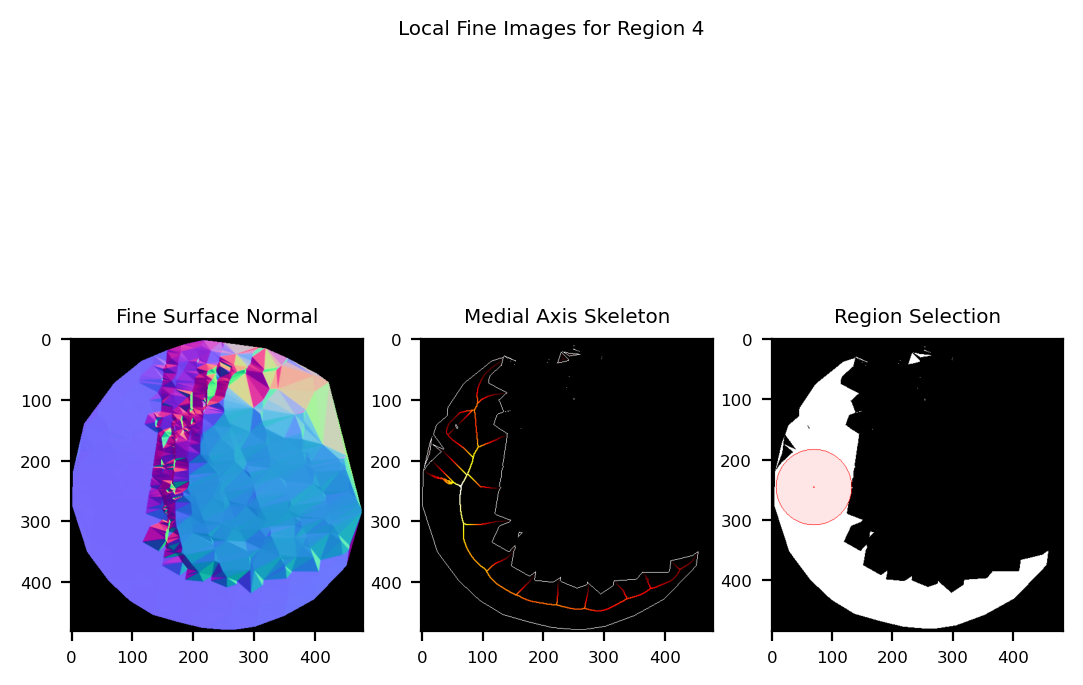

<Figure size 640x480 with 0 Axes>

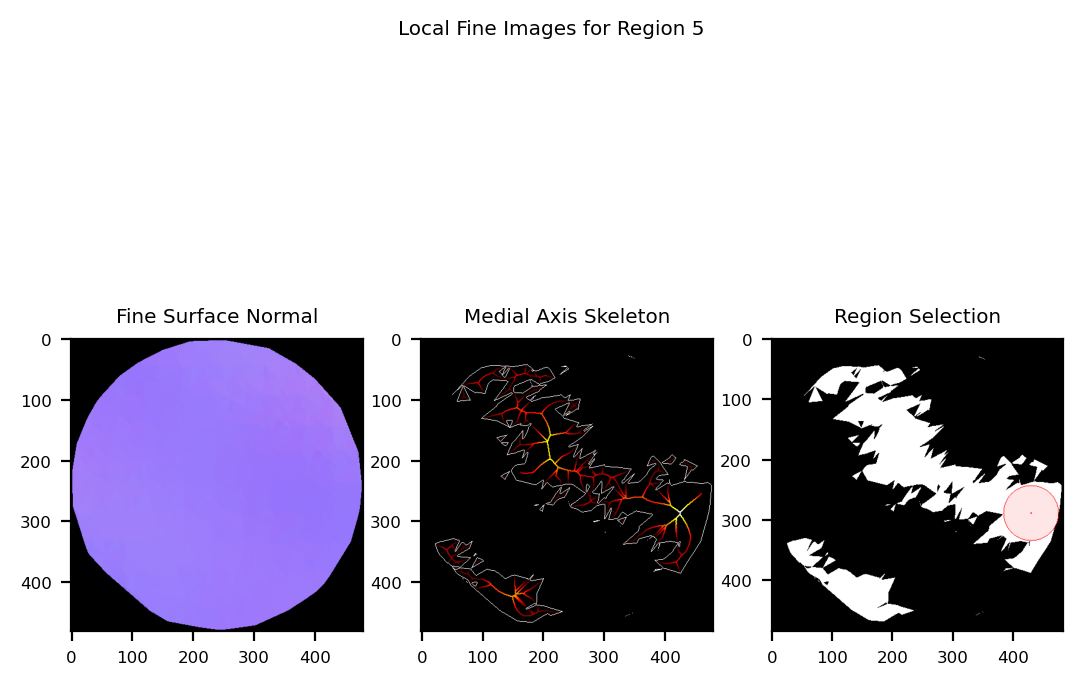

<Figure size 640x480 with 0 Axes>

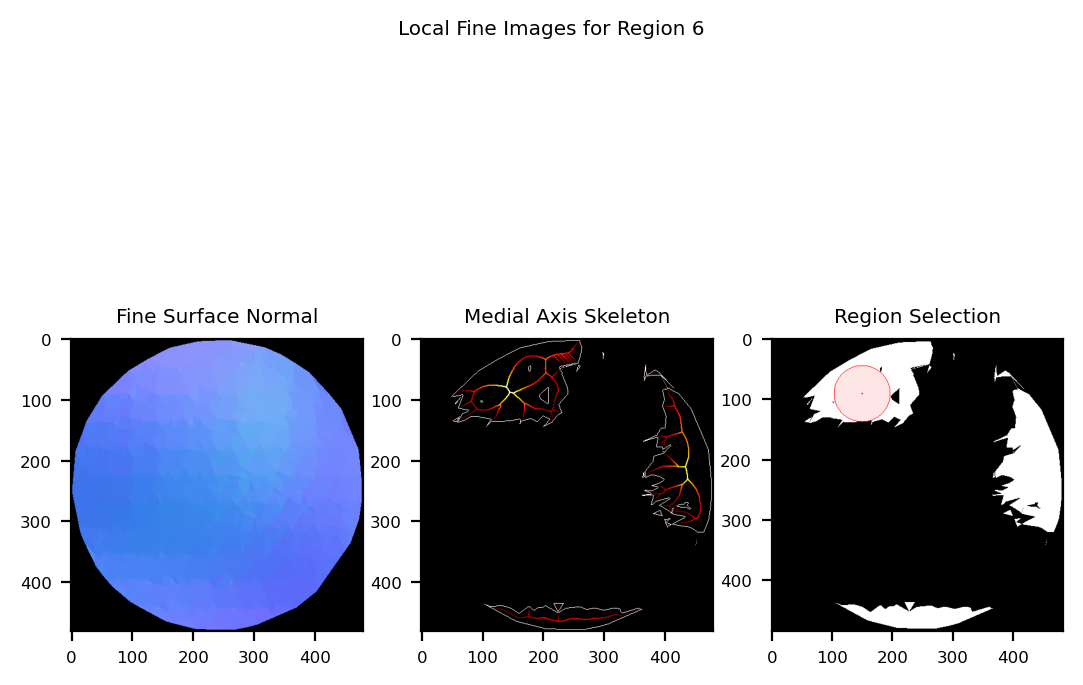

<Figure size 640x480 with 0 Axes>

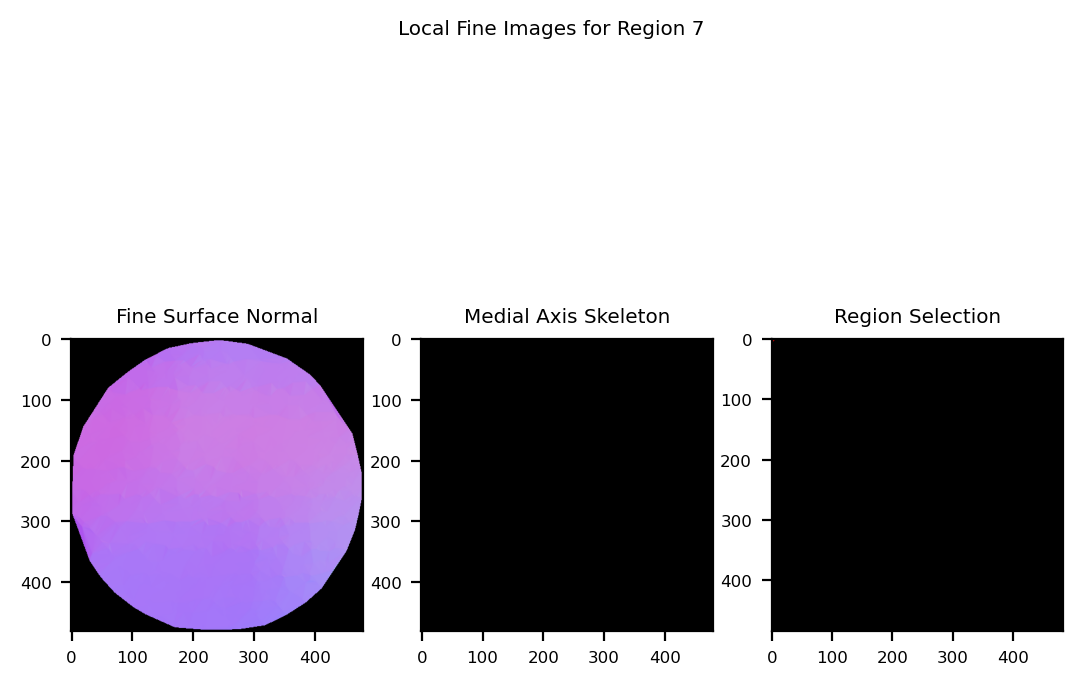

<Figure size 640x480 with 0 Axes>

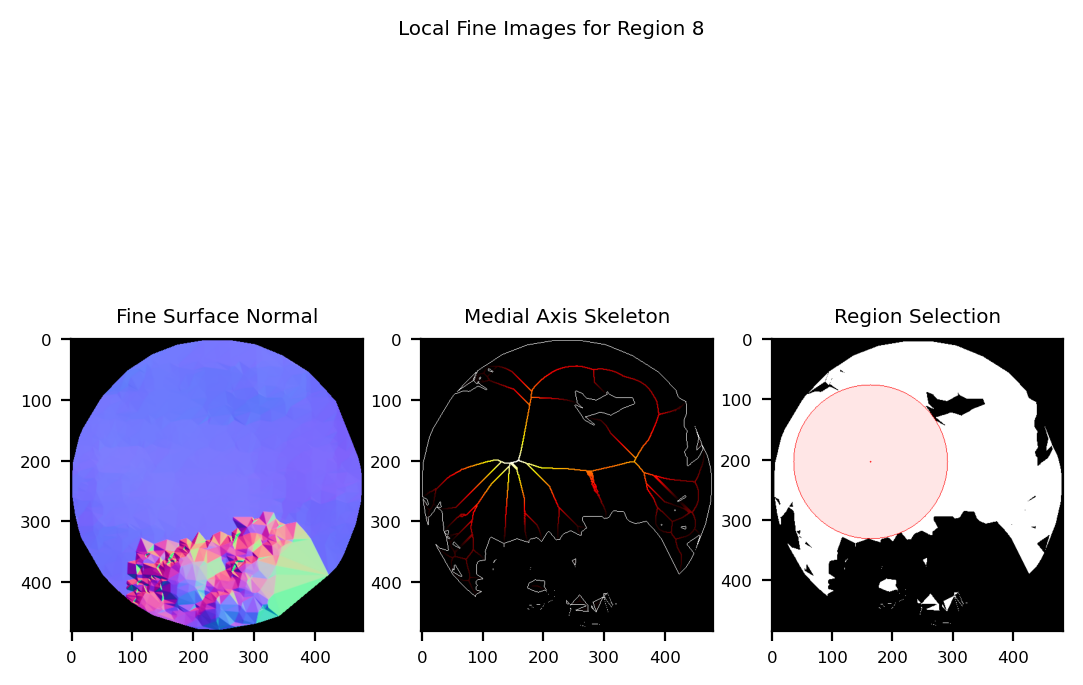

<Figure size 640x480 with 0 Axes>

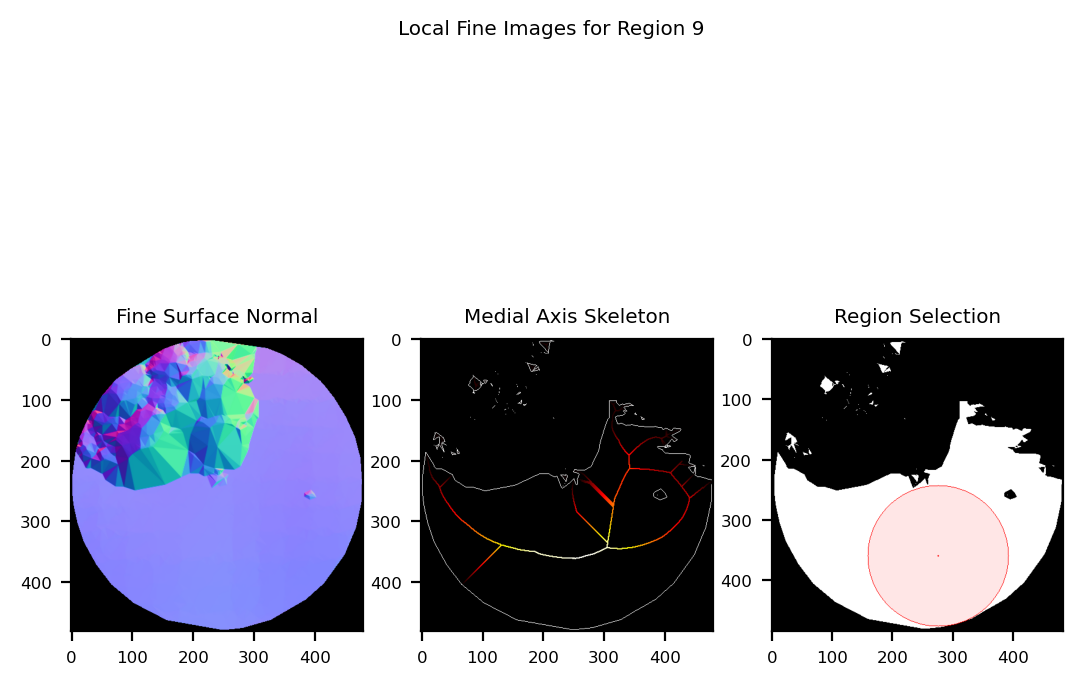

<Figure size 640x480 with 0 Axes>

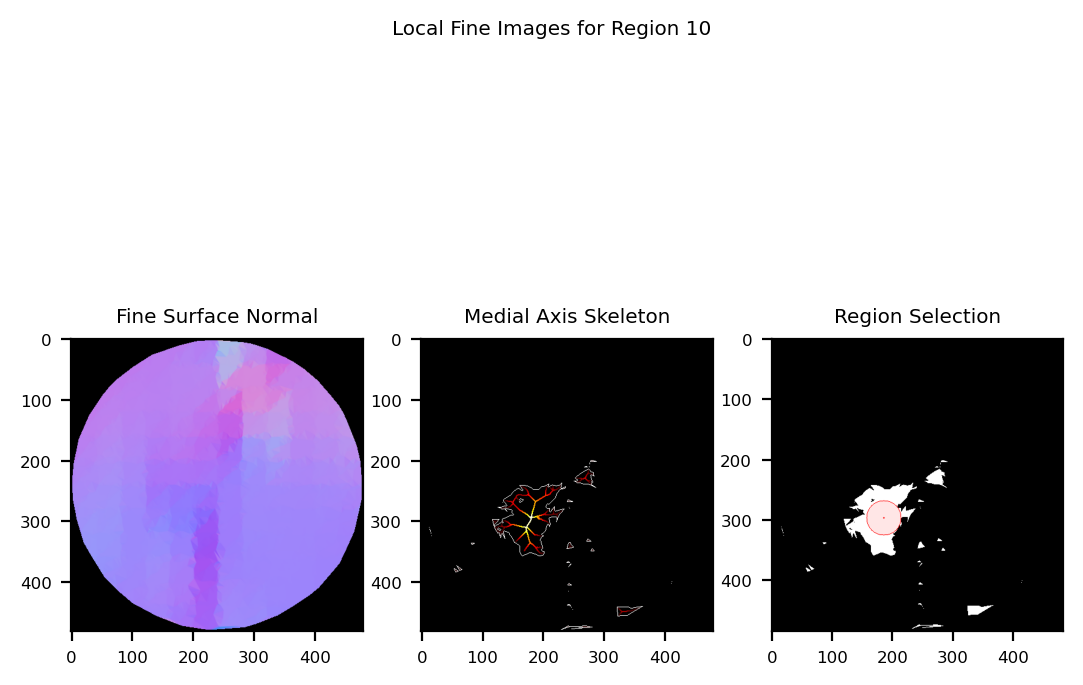

<Figure size 640x480 with 0 Axes>

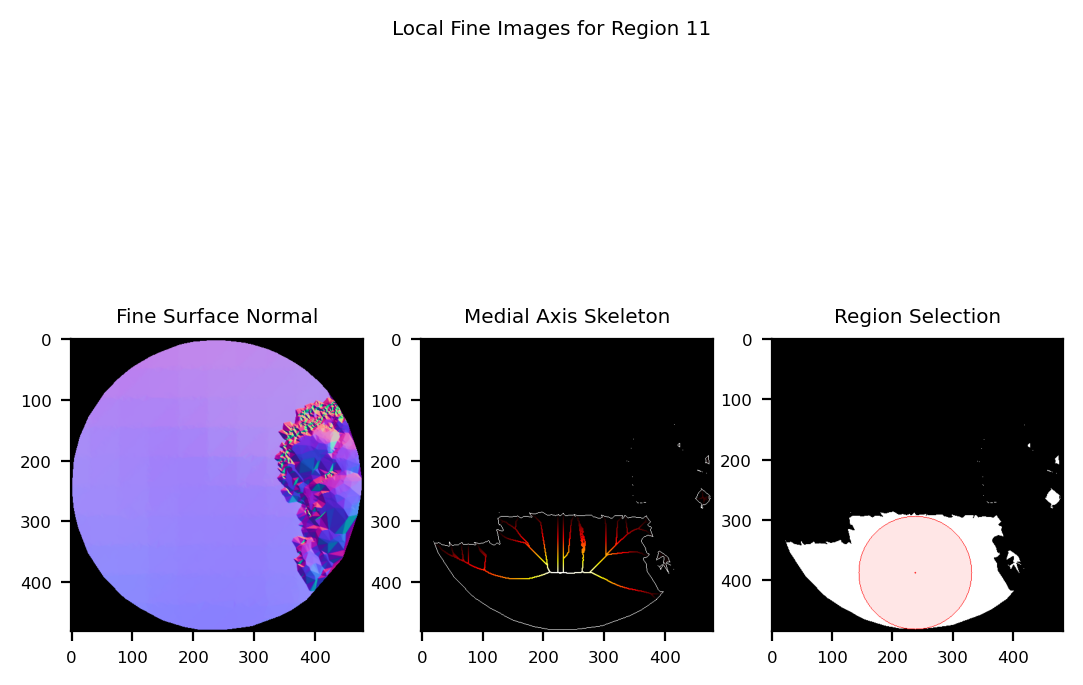

<Figure size 640x480 with 0 Axes>

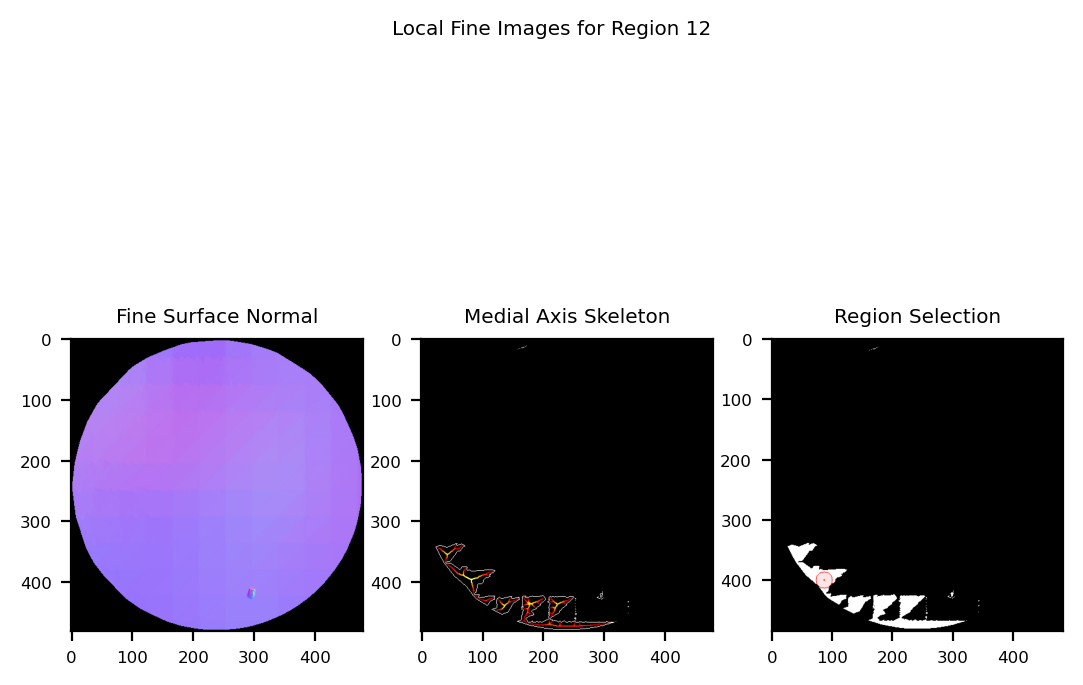

In [6]:
halss_global = multithread_fine_site_selection(halss_global, flags, params)
plot_fine_images(halss_global)